In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 199 kB 48.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=98756634bfde507edb080a863d8f1ac7e674afd4cf3f55c530da0ef4eb78fc12
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.3 MB/s 


In [ ]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql import functions as f, udf
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import col,isnan, when, count
from textblob import TextBlob
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import format_number as fmt
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer,StopWordsRemover,Word2Vec
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import re
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import folium
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import when

In [ ]:
# create the session
conf = pyspark.SparkConf()
# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
# read the data and display
data = spark.read.csv('/content/drive/MyDrive/Scraped Twitter Data.csv',header='true')
# data = spark.read.csv('/content/drive/MyDrive/23-07-2022/Scraped Twitter Data.csv',header='true')
data.show(5)

+---+---------+-------------+--------+-------------------+--------------------+-----------+
|_c0|user_name|user_location|language|               date|                text|   hashtags|
+---+---------+-------------+--------+-------------------+--------------------+-----------+
|  0| Reported|          NYC|      en|2022-07-20 20:51:16|The driver T73791...|['nyctaxi']|
|  1| Reported|          NYC|      en|2022-07-20 20:35:58|The driver Y20081...|['nyctaxi']|
|  2| Reported|          NYC|      en|2022-07-20 20:33:52|The driver T78776...|['nyctaxi']|
|  3| Reported|          NYC|      en|2022-07-20 20:30:50|The driver T75437...|['nyctaxi']|
|  4| Reported|          NYC|      en|2022-07-20 20:25:01|The driver Y20272...|['nyctaxi']|
+---+---------+-------------+--------+-------------------+--------------------+-----------+
only showing top 5 rows



In [ ]:
data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- language: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)



In [ ]:
# find the null values in the data
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+---------+-------------+--------+----+----+--------+
|_c0|user_name|user_location|language|date|text|hashtags|
+---+---------+-------------+--------+----+----+--------+
|  0|        0|            3|       2|   2|   2|      77|
+---+---------+-------------+--------+----+----+--------+



In [ ]:
data=data.na.drop()

In [ ]:
# find the null values in the data
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+---------+-------------+--------+----+----+--------+
|_c0|user_name|user_location|language|date|text|hashtags|
+---+---------+-------------+--------+----+----+--------+
|  0|        0|            0|       0|   0|   0|       0|
+---+---------+-------------+--------+----+----+--------+



In [ ]:
def removePattern(inputText, pattern):
    r = re.findall(pattern, inputText)
    for i in r:
        inputText = re.sub(i, '', inputText)
    return inputText

def cleanTweet(text):
    '''
    Remove twitter return handles (RT @xxx:)
    '''
    txt = removePattern(text, 'RT @[\w]*:')
    '''
    Remove twitter handles (@xxx)
    '''
    txt = removePattern(txt, '@[\w]*')
    '''
    Remove URL links (httpxxx)
    '''
    txt = removePattern(txt, 'https?://[A-Za-z0-9./]*')
    '''
    Remove special characters, numbers, punctuations
    '''
    txt = re.sub('[^A-Za-z]+', ' ', txt)
    return txt

def getCleanTweetText(filteredTweetText):
    return ' '.join(filteredTweetText)

def getSentimentScore(tweetText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(tweetText)
    return float(vs['compound'])

def getSentiment(score):
    if score>0:
      return 1
    elif score<0:
      return -1
    else:
      return 0

    # return 1 if score > 0 else 0


def getTweetArray(tweet):
    return tweet.split(' ')

In [ ]:
udfCleanTweet = udf(cleanTweet, StringType())
dfCleanTweet=data.withColumn('cleanTweetText', udfCleanTweet('text'))
dfCleanTweet.select('text','cleanTweetText').show(5)

+--------------------+--------------------+
|                text|      cleanTweetText|
+--------------------+--------------------+
|The driver T73791...|The driver T C bl...|
|The driver Y20081...|The driver Y C ra...|
|The driver T78776...|The driver T C pa...|
|The driver T75437...|The driver T C bl...|
|The driver Y20272...|The driver Y C ra...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
tokenizer = Tokenizer(inputCol='cleanTweetText', outputCol='words')
dfCleanTweetTokenized = tokenizer.transform(dfCleanTweet)
dfCleanTweetTokenized.select('text','cleanTweetText','words').show(5)

+--------------------+--------------------+--------------------+
|                text|      cleanTweetText|               words|
+--------------------+--------------------+--------------------+
|The driver T73791...|The driver T C bl...|[the, driver, t, ...|
|The driver Y20081...|The driver Y C ra...|[the, driver, y, ...|
|The driver T78776...|The driver T C pa...|[the, driver, t, ...|
|The driver T75437...|The driver T C bl...|[the, driver, t, ...|
|The driver Y20272...|The driver Y C ra...|[the, driver, y, ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
remover = StopWordsRemover(inputCol='words', outputCol='filteredTweetText')
dfStopwordRemoved=remover.transform(dfCleanTweetTokenized)
dfStopwordRemoved.select('text','cleanTweetText','words','filteredTweetText').show(5)

+--------------------+--------------------+--------------------+--------------------+
|                text|      cleanTweetText|               words|   filteredTweetText|
+--------------------+--------------------+--------------------+--------------------+
|The driver T73791...|The driver T C bl...|[the, driver, t, ...|[driver, c, block...|
|The driver Y20081...|The driver Y C ra...|[the, driver, y, ...|[driver, y, c, ra...|
|The driver T78776...|The driver T C pa...|[the, driver, t, ...|[driver, c, parke...|
|The driver T75437...|The driver T C bl...|[the, driver, t, ...|[driver, c, block...|
|The driver Y20272...|The driver Y C ra...|[the, driver, y, ...|[driver, y, c, ra...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
udfCleanTweetText = udf(getCleanTweetText, StringType())
dfFilteredCleanedTweet = dfStopwordRemoved.withColumn('filteredCleanedTweetText', udfCleanTweetText('filteredTweetText'))
dfFilteredCleanedTweet.select('filteredCleanedTweetText').show(5)

+------------------------+
|filteredCleanedTweetText|
+------------------------+
|    driver c blocked ...|
|    driver y c ran re...|
|    driver c parked i...|
|    driver c blocked ...|
|    driver y c ran re...|
+------------------------+
only showing top 5 rows



In [ ]:
udfSentimentScore = udf(getSentimentScore, FloatType())
dfSentimentScore = dfFilteredCleanedTweet.withColumn('sentimentScore', udfSentimentScore('filteredCleanedTweetText'))
dfSentimentScore.select('filteredCleanedTweetText','sentimentScore').show(5)

+------------------------+--------------+
|filteredCleanedTweetText|sentimentScore|
+------------------------+--------------+
|    driver c blocked ...|       -0.2732|
|    driver y c ran re...|        -0.296|
|    driver c parked i...|           0.0|
|    driver c blocked ...|       -0.2732|
|    driver y c ran re...|        -0.296|
+------------------------+--------------+
only showing top 5 rows



In [ ]:
udfSentiment = udf(getSentiment, IntegerType())
dfSentiment = dfSentimentScore.withColumn('Polarity', udfSentiment('sentimentScore'))
dfSentiment.select('filteredCleanedTweetText','sentimentScore','Polarity').show(5)

+------------------------+--------------+--------+
|filteredCleanedTweetText|sentimentScore|Polarity|
+------------------------+--------------+--------+
|    driver c blocked ...|       -0.2732|      -1|
|    driver y c ran re...|        -0.296|      -1|
|    driver c parked i...|           0.0|       0|
|    driver c blocked ...|       -0.2732|      -1|
|    driver y c ran re...|        -0.296|      -1|
+------------------------+--------------+--------+
only showing top 5 rows



In [ ]:
dfSentiment.show(5)

+---+---------+-------------+--------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------------+--------------+--------+
|_c0|user_name|user_location|language|               date|                text|   hashtags|      cleanTweetText|               words|   filteredTweetText|filteredCleanedTweetText|sentimentScore|Polarity|
+---+---------+-------------+--------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------------+--------------+--------+
|  0| Reported|          NYC|      en|2022-07-20 20:51:16|The driver T73791...|['nyctaxi']|The driver T C bl...|[the, driver, t, ...|[driver, c, block...|    driver c blocked ...|       -0.2732|      -1|
|  1| Reported|          NYC|      en|2022-07-20 20:35:58|The driver Y20081...|['nyctaxi']|The driver Y C ra...|[the, driver, y, ...|[driver, y, c, ra...|    driver y c ran re...|     

In [ ]:
dfSentiment.groupBy('Polarity').count().show()
dfPlotVaderSentiment=dfSentiment.groupBy('Polarity').count().toPandas()
dfPlotVaderSentiment

+--------+-----+
|Polarity|count|
+--------+-----+
|      -1|   81|
|       1|    5|
|       0|   17|
+--------+-----+



,Polarity,count
0,-1,81
1,1,5
2,0,17


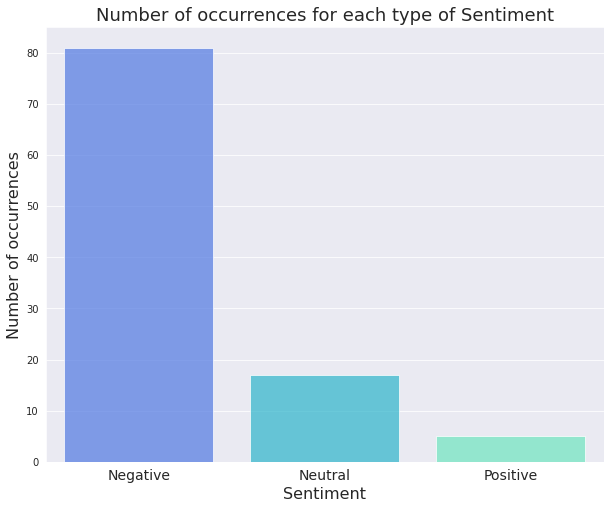

In [ ]:
sentimentsList=['Negative','Neutral','Positive']
sns.set_style('darkgrid')
sns.set_palette('rainbow')
plt.figure(figsize=(10,8))
sns.barplot(x='Polarity', y='count',data=dfPlotVaderSentiment, alpha=0.7)
plt.title('Number of occurrences for each type of Sentiment',fontsize=18)
plt.xticks(np.arange(3),sentimentsList)
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.xlabel('Sentiment',fontsize=16)
plt.ylabel('Number of occurrences',fontsize=16)
plt.show()

In [ ]:
dfSentiment=dfSentiment.withColumn("Sentiment", lit('Negative'))

In [ ]:
data = dfSentiment.withColumn("Sentiment", when(dfSentiment["Polarity"] == 0, 'Neutral').otherwise(dfSentiment["Sentiment"]))

In [ ]:
data = data.withColumn("Sentiment", when(data["Polarity"] == 1, 'Positive').otherwise(data["Sentiment"]))

In [ ]:
data.show(100)

+---+-----------------+-------------+--------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------+--------+---------+
|_c0|        user_name|user_location|language|               date|                text|            hashtags|      cleanTweetText|               words|   filteredTweetText|filteredCleanedTweetText|sentimentScore|Polarity|Sentiment|
+---+-----------------+-------------+--------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------+--------+---------+
|  0|         Reported|          NYC|      en|2022-07-20 20:51:16|The driver T73791...|         ['nyctaxi']|The driver T C bl...|[the, driver, t, ...|[driver, c, block...|    driver c blocked ...|       -0.2732|      -1| Negative|
|  1|         Reported|          NYC|      en|2022-07-20 20:35:58|The driver

In [ ]:
from pyspark.sql.functions import date_format
# df = data.withColumn('dayofweek', F.dayofweek(data['date']))
df = data.withColumn("Time",date_format("date","HH:mm:ss"))
df = df.withColumn('hour', F.hour(data['date']))
df = df.withColumn("Minutes", F.minute(data['date']))
df = df.withColumn("day", date_format('date', 'EEEE'))
# df = df.withColumn("Time",to_timestamp(col("date"),"HH:mm:ss.SSS"))

In [ ]:
df.show()

+---+---------+-------------+--------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------------+--------------+--------+---------+--------+----+-------+---------+
|_c0|user_name|user_location|language|               date|                text|   hashtags|      cleanTweetText|               words|   filteredTweetText|filteredCleanedTweetText|sentimentScore|Polarity|Sentiment|    Time|hour|Minutes|      day|
+---+---------+-------------+--------+-------------------+--------------------+-----------+--------------------+--------------------+--------------------+------------------------+--------------+--------+---------+--------+----+-------+---------+
|  0| Reported|          NYC|      en|2022-07-20 20:51:16|The driver T73791...|['nyctaxi']|The driver T C bl...|[the, driver, t, ...|[driver, c, block...|    driver c blocked ...|       -0.2732|      -1| Negative|20:51:16|  20|     51|Wednesday|
|  1| Reported| 

In [ ]:
df.toPandas().to_csv('/content/drive/MyDrive/clientmysql/Sentiment.csv',index=False)